In [1]:
import os

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]


78

In [3]:
import tifffile as tif
import numpy as np
train_data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
label_data = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])

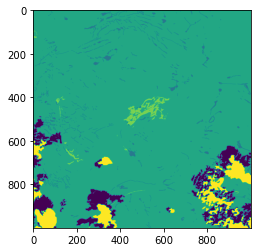

In [4]:
import matplotlib.pyplot as plt
plt.imshow(label_data[0])

In [5]:
import tensorflow as tf
label_data = tf.one_hot(indices = label_data, depth = 7, dtype=tf.int8)

TensorShape([78, 1000, 1000, 7])

In [41]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise, Dropout, BatchNormalization, Activation, Conv2DTranspose



def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def unet4(img_height, img_width, img_depth, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, img_depth), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [42]:

model = unet4(512, 512, 10, nclasses=7, filters=64)

In [43]:
train_data = train_data[:,:512,:512]
label_data = label_data[:,:512,:512]

In [44]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
model.compile(loss = "categorical_crossentropy", optimizer=Adam())

In [47]:
model.fit(train_data, label_data, batch_size=13, 
            steps_per_epoch=len(train_data) / 13, epochs=30)

Epoch 1/30
6/6 [==============================] - 6s 1s/step - loss: 0.9595
Epoch 2/30
6/6 [==============================] - 6s 1s/step - loss: 1.0074
Epoch 3/30
6/6 [==============================] - 6s 1s/step - loss: 0.9542
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 0.9657
Epoch 5/30
6/6 [==============================] - 7s 1s/step - loss: 0.9899
Epoch 6/30
6/6 [==============================] - 6s 1s/step - loss: 0.9317
Epoch 7/30
6/6 [==============================] - 6s 1s/step - loss: 0.9374
Epoch 8/30
6/6 [==============================] - 7s 1s/step - loss: 0.9522
Epoch 9/30
6/6 [==============================] - 6s 1s/step - loss: 0.9115
Epoch 10/30
6/6 [==============================] - 7s 1s/step - loss: 0.9150
Epoch 11/30
6/6 [==============================] - 6s 1s/step - loss: 0.9049
Epoch 12/30
6/6 [==============================] - 6s 1s/step - loss: 0.8674
Epoch 13/30
6/6 [==============================] - 6s 1s/step - loss: 0.8678
Epoch 14

In [48]:
pred = model.predict(train_data[:13])

In [49]:
pred_im = np.argmax(pred[0], axis = 2)

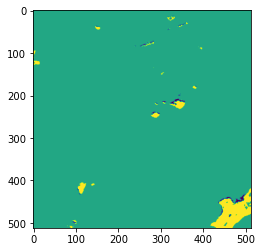

In [50]:
import matplotlib.pyplot as plt

plt.imshow(pred_im)

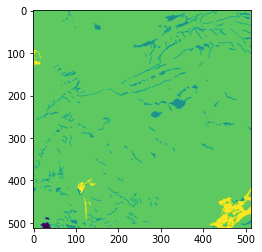

In [53]:
plt.imshow(np.argmax(label_data[0], axis = 2))

In [3]:
from unet import unet4

img_rows = 512
img_cols = 512
img_channels = 10
nb_classes = 7

checkpoint_filepath = "tmp/checkpoint"
model = unet4(img_rows, img_cols, img_channels, nclasses=nb_classes, filters=32)
model.load_weights(checkpoint_filepath)

In [4]:
import os
import tifffile as tif
import numpy as np
from unet import unet4
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam

# -- Throtling GPU usage by Tensorflow--

tf.autograph.set_verbosity(0)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


# -- Loading the datasets --

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])
print(data.shape)
# -- Data Preprocessing --

#Splitting all images in four patches
data = np.concatenate((data[:,:512, :512,:], data[:,:512, 488:,:], data[:, 488:,:512,:],data[:, 488:, 488:,:]), axis = 0)
labels = np.concatenate((labels[:,:512, :512], labels[:,:512, 488:], labels[:, 488:,:512],labels[:, 488:, 488:]), axis = 0)
print(data.shape)

## One-Hot Encoding
labels = tf.one_hot(indices = labels, depth = 7, dtype=tf.int8)

## Splitting into training, validation and testing dataset
train_data, train_labels = data[:61], labels[:61]
val_data, val_labels = data[61:71], labels[61:71]
test_data, test_labels = data[71:], labels[71:]

(78, 1000, 1000, 10)
(312, 512, 512, 10)


In [5]:
test_pred = model.predict(test_data)

In [7]:
test_pred.shape

(241, 512, 512, 7)

In [8]:
test_data.shape

(241, 512, 512, 10)

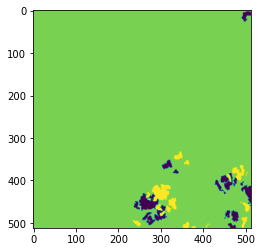

In [11]:
import matplotlib.pyplot as plt

plt.imshow(np.argmax(test_labels[0], axis = 2))

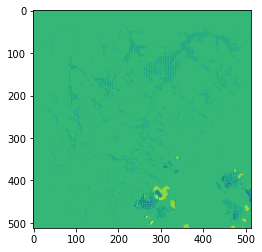

In [13]:
plt.imshow(np.argmax(test_pred[0], axis = 2))

In [14]:
from sklearn.metrics import jaccard_score

In [19]:
jaccard_score(np.argmax(test_labels[0], axis = 2).flatten(), np.argmax(test_pred[0], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "weighted")

0.9330453238556237

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, label_mode="categorical")

TypeError: __init__() got an unexpected keyword argument 'label_mode'

In [2]:
import numpy as np
import tifffile as tif

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])
print(data.shape)
# -- Data Preprocessing --

#Splitting all images in four patches
data = np.concatenate((data[:,:512, :512,:], data[:,:512, 488:,:], data[:, 488:,:512,:],data[:, 488:, 488:,:]), axis = 0)
labels = np.concatenate((labels[:,:512, :512], labels[:,:512, 488:], labels[:, 488:,:512],labels[:, 488:, 488:]), axis = 0)
print(data.shape)



## Splitting into training, validation and testing dataset
train_data, train_labels = data[:4*61], labels[:4*61]
val_data, val_labels = data[4*61:4*71], labels[4*61:4*71]
test_data, test_labels = data[4*71:], labels[4*71:]

del data
del labels

(78, 1000, 1000, 10)
(312, 512, 512, 10)


In [2]:
l, x, y = train_labels.shape
new_shape = (l, x, y, 1)

train_labels_r = np.reshape(train_labels, new_shape)

In [3]:
train_labels_r.shape

(244, 512, 512, 1)

In [6]:
import tensorflow as tf



image_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
mask_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

seed = 1
image_datagen.fit(train_data, augment=True, seed=seed)
mask_datagen.fit(train_labels_r, augment=True, seed=seed)

image_generator = image_datagen.flow(
    train_data,
    seed=seed)



mask_generator = mask_datagen.flow(
    train_labels_r,
    seed=seed)

In [24]:
def image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        mask_squeezed = np.squeeze(mask)
        mask_one_hot = tf.one_hot(mask_squeezed, depth=7, dtype=tf.int8)

        yield img, mask_one_hot

In [25]:
gen = image_mask_generator(image_generator, mask_generator)

In [26]:
a = next(gen)

In [28]:
import matplotlib.pyplot as plt

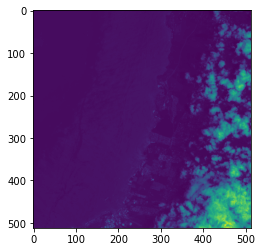

In [31]:
plt.imshow(a[0][0][:,:,1])

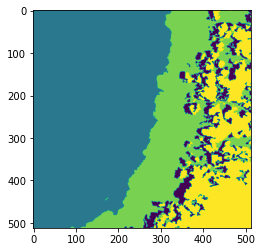

In [32]:
plt.imshow(np.argmax(a[1][0], axis = 2))

In [1]:
from unet import unet4

checkpoint_filepath = "tmp/checkpoint"
model = unet4(256, 256, 10, nclasses=7, filters=32)
model.load_weights(checkpoint_filepath)


pred = model.predict(test_data)

NameError: name 'test_data' is not defined

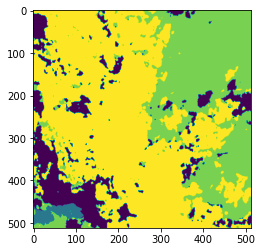

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.argmax(pred[1], axis=2))

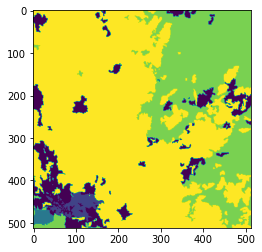

In [8]:
plt.imshow(test_labels[1])

ot).optimizer's state 'm' for (root).layer_with_weights-2.kernel


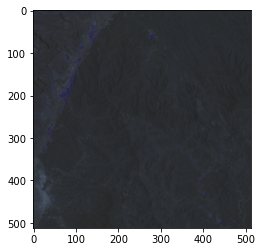

In [18]:
plt.imshow(test_data[0][:,:,2:]/np.amax(test_data))

In [26]:
from sklearn.metrics import jaccard_score


jaccard_score(test_labels[0].flatten(), np.argmax(pred[0], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "micro")

0.9988486246401952

In [23]:
test_labels[0]

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=uint8)

In [24]:
np.argmax(pred[0], axis = 2)

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [11]:
from sklearn.utils import class_weight
import numpy as np
import tifffile as tif

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])

class_weights = class_weight.compute_class_weight(dict, np.unique(labels.flatten()), y=labels.flatten())

TypeError: object of type 'type' has no len()

In [4]:
class_weights = np.count

(78000000,)

In [5]:
labels.shape

(78, 1000, 1000)

In [13]:
import numpy as np
unique, counts = np.unique(labels.flatten(), return_counts=True)
class_weights = dict(zip(unique, labels.size/counts))

In [14]:
class_weights

{0: 13.9701701047315,
 1: 379.6267004112623,
 2: 15.04956516403833,
 3: 18.38946048152095,
 4: 1.639716903297086,
 5: 5.125664874304897,
 6: 1529411.7647058824}

In [2]:
import os
import tifffile as tif
import numpy as np
from unet import unet4
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# -- Throtling GPU usage by Tensorflow--

# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
#   except RuntimeError as e:
#     print(e)

# -- Loading the datasets --

filenames = [file[:-8] for file in os.listdir("./data-landsat/") if "_data.tif" in file]

data = np.array([tif.imread("data-landsat/" + filenames[i]+"data.tif") for i in range(len(filenames))])
labels = np.array([tif.imread("data-landsat/" + filenames[i]+"labels.tif") for i in range(len(filenames))])

print("Initial length :", data.shape)

#Computing classes imbalance
unique, counts = np.unique(labels.flatten(), return_counts=True)
class_weights = dict(zip(unique, labels.size/counts))

# -- Data Preprocessing --

#Splitting all images in four patches

n_split = 4
size = 1024//n_split
stride = (1000-size)//(n_split-1)

data_temp = np.zeros((n_split**2*len(data), size, size, 10))
label_temp = np.zeros((n_split**2*len(data), size, size))

for i in range(n_split):
  for j in range(n_split):
    data_temp[(i*n_split+j)*len(data):(i*n_split+j+1)*len(data)] = data[:, i*stride:i*stride+256, j*stride:j*stride+256, :]
    label_temp[(i*n_split+j)*len(data):(i*n_split+j+1)*len(data)] = labels[:, i*stride:i*stride+256, j*stride:j*stride+256]

data = data_temp
labels = label_temp

del data_temp

## Splitting into training, validation and testing dataset
train_data, train_labels = data[:n_split**2*61], labels[:n_split**2*61]
val_data, val_labels = data[n_split**2*61:n_split**2*71], labels[n_split**2*61:n_split**2*71]
test_data, test_labels = data[n_split**2*71:], labels[n_split**2*71:]

Initial length : (78, 1000, 1000, 10)


In [3]:
from unet import unet4

checkpoint_filepath = "tmp/checkpoint"
model = unet4(256, 256, 10, nclasses=7, filters=32)
model.load_weights(checkpoint_filepath)


pred = model.predict(test_data)

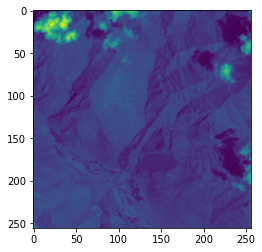

In [5]:
plt.imshow(test_data[0][:,:,0])

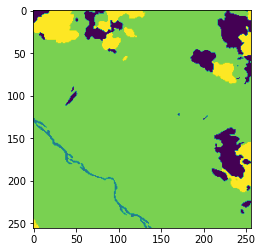

In [4]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.imshow(np.argmax(pred[0], axis=2))

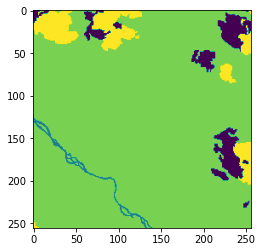

In [4]:
plt.imshow(test_labels[0])

In [13]:
from sklearn.metrics import jaccard_score, f1_score

jaccard_score(test_labels[0].flatten(), np.argmax(pred[0], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "weighted")


0.9288886602911202

In [23]:
for i in range(len(test_labels)):
    print(jaccard_score(test_labels[i].flatten(), np.argmax(pred[i], axis = 2).flatten(), labels = [0,1,2,3,4,5,6], average = "macro"))

0.43031729784762185
0.3085087099933533
0.27931110120393715
0.29329955480778175
0.37609120692033576
0.1618764232888199
0.14285714285714285
0.4419932069187902
0.2717254631817462
0.22820709906253964
0.2423942773051721
0.4397403425642293
0.49384111038534334
0.3660439486331462
0.1826155368166543
0.32811375294519735
0.37555789516608673
0.3432119954179354
0.35725154217416016
0.24837848735509307
0.26343683511830146
0.4791814420135956
0.29156066590706725
0.30791208784073115
0.142852783203125
0.41174101590969564
0.2123744003042099
0.34529460781502025
0.3580430804583992
0.46189462416023425
0.14284406389508927
0.14285714285714285
0.35599779721513247
0.1303253173828125
0.2854802256969352
0.23569908570306858
0.3802939961802409
0.393162624699221
0.32819118941624087
0.44342274442450386
0.3467085766004926
0.3708959592871851
0.3673785762975693
0.14285714285714285
0.09483646718004154
0.2749694285000396
0.14414769052446919
0.21162247640071813
0.2544453839978803
0.3097221645623331
0.36076900406762125
0.250

In [24]:
class_weights

{0: 13.9701701047315,
 1: 379.6267004112623,
 2: 15.04956516403833,
 3: 18.38946048152095,
 4: 1.639716903297086,
 5: 5.125664874304897,
 6: 1529411.7647058824}

In [9]:
class_weights = dict(zip(unique, counts/labels.size))


In [10]:
class_weights

{0: 0.06826504682883239,
 1: 0.0025121370951334634,
 2: 0.06336889511499649,
 3: 0.05185983119866787,
 4: 0.5816091268490522,
 5: 0.18605865576328376,
 6: 6.235562838040865e-07}

In [11]:
labels.size

81788928

In [2]:
import tensorflow as tf

# -- Throtling GPU use -- 
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise, Dropout, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam


In [1]:

def ConvBlock(tensor, nb_filters, kernel_size=3, padding='same', initializer='he_normal', activation="relu"):
    x = Conv2D(filters=nb_filters, kernel_size=kernel_size, padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters=nb_filters, kernel_size=kernel_size, padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def DeconvBlock(tensor, residual, nb_filters, kernel_size=3, padding="same", strides=(2,2)):
    y = Conv2DTranspose(nb_filters, kernel_size=(kernel_size, kernel_size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = ConvBlock(y, nb_filters, kernel_size)
    return y

def Unet(shape, nb_filters_0=32, exp=1, kernel_size=3, initialization="glorot_uniform", activation="relu", sigma_noise=0, output_channels=1, drop=0.0):
    
    input_layer = Input(shape=shape)

    conv1 = ConvBlock(input_layer, nb_filters=nb_filters, kernel_size=kernel_size, initializer=initialization, activation=activation )
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    if drop > 0.0: pool1 = Dropout(dropout)(pool1)

    conv2 = ConvBlock(pool1, nb_filters=nb_filters * 2 **(1 * exp), kernel_size=kernel_size, initializer=initialization, activation=activation )
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    if drop > 0.0: pool2 = Dropout(dropout)(pool2)

    conv3 = ConvBlock(pool2, nb_filters=nb_filters * 2 **(2 * exp), kernel_size=kernel_size, initializer=initialization, activation=activation )
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    if drop > 0.0: pool3 = Dropout(dropout)(pool3)

    conv4 = ConvBlock(pool3, nb_filters=nb_filters * 2 **(3 * exp), kernel_size=kernel_size, initializer=initialization, activation=activation )
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    if drop > 0.0: pool4 = Dropout(dropout)(pool4)

    conv5 = ConvBlock(pool4, nb_filters=nb_filters * 2 **(4 * exp), kernel_size=kernel_size, initializer=initialization, activation=activation )
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    if drop > 0.0: pool5 = Dropout(dropout)(pool5)

    deconv6 = DeconvBlock(conv5, residual=conv4, nb_filters=nb_filters * 2 **(3 * exp), kernel_size=kernel_size)
    if drop > 0.0: deconv6 = Dropout(drop)(deconv6)

    deconv7 = DeconvBlock(deconv6, residual=conv3, nb_filters=nb_filters * 2 **(2 * exp), kernel_size=kernel_size)
    if drop > 0.0: deconv7 = Dropout(drop)(deconv7)

    deconv8 = DeconvBlock(deconv7, residual=conv2, nb_filters=nb_filters * 2 **(1 * exp), kernel_size=kernel_size)
    if drop > 0.0: deconv8 = Dropout(drop)(deconv8)

    deconv9 = DeconvBlock(deconv8, residual=conv1, nb_filters=nb_filters, kernel_size=kernel_size)
    if drop > 0.0: deconv9 = Dropout(drop)(deconv9)

    if sigma_noise > 0:
        deconv9 = GaussianNoise(sigma_noise)(deconv9)

    output_layer = Conv2D(filters=output_channels, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Activation('softmax')(output_layer)


    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

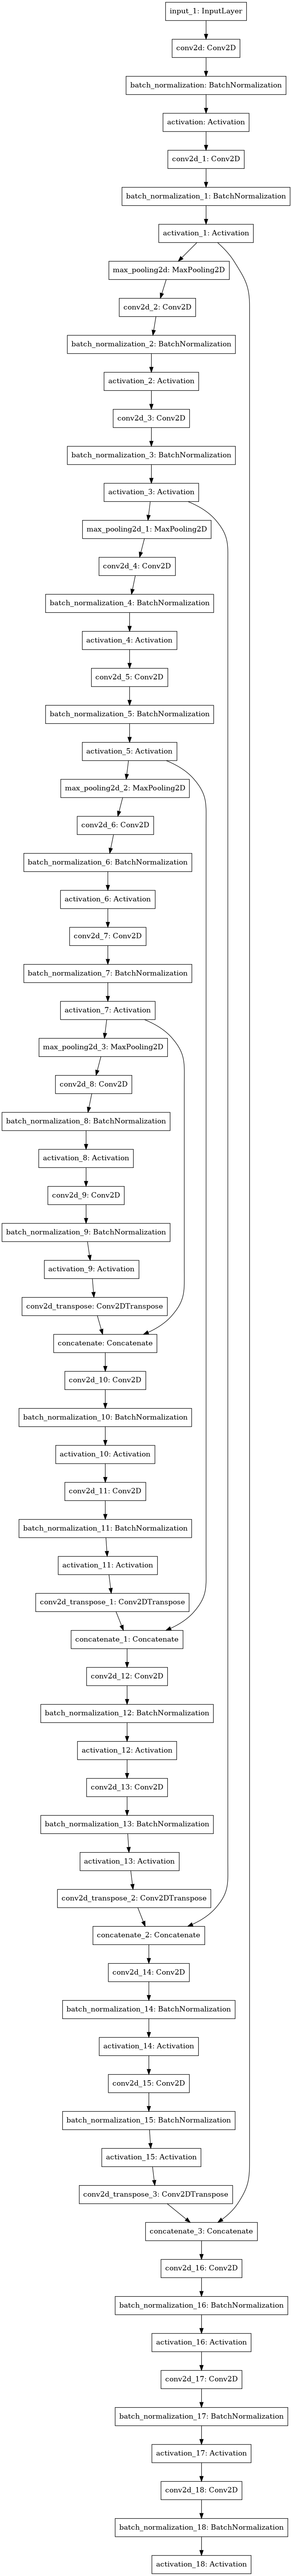

In [3]:
img_rows, img_cols, img_channels = 256, 256, 10
nb_filters = 32
 
model = Unet((img_rows, img_cols, img_channels), output_channels=7)

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [4]:
print(model.summary())

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 10 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 2912        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [5]:
m = 0 
for i in range(0, 20):
    m = 1.1*m
    m += 10000

print(m)

572749.9949325606
